## Import Requirements

In [1]:
from copy import copy
from time import time
import matplotlib
matplotlib.rc('font',family='serif')
from matplotlib import pyplot as plt

import numpy as np
from scipy import optimize

from sequence.components.polarization_fock.node_definitions import *
from sequence.kernel.timeline import Timeline
from sequence.kernel.quantum_manager import POLARIZATION_FOCK_FORMALISM, POLARIZATION_FOCK_TENSOR_FORMALISM

import json
import csv

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Simulation Setup

In [2]:
# Working simulation setup

params = {
    # Light source
    "MEAN_PHOTON_NUM" : .0597,

    # detectors
    "SIGNAL_DET_EFFICIENCY" : 1,
    "IDLER_DET_EFFICIENCY" : 1, 

    # fibers
    "SIGNAL_DIST" : 6.1, 
    "IDLER_DIST" : 6.1,  
    "QUNATUM_ATTENUATION" : 7.1/6.1,  # attenuation rate of optical fibre (in dB/km)
    "QUANTUM_INDEX" : 1.471,

    # experiment settings
    "num_bs_trials_per_phase" : 1,
    "signal_angles" : np.linspace(0, 2*np.pi, 20),
    "idler_angles" : [0, np.pi/2, np.pi, 3*np.pi/2],
    "MODE_NUM" : 4,
    "truncation" : 5,

    # Future development params:
    "QUANTUM_WAVELENGTH" : 1550,
    "SPDC_FREQUENCY" : 1e10,
    "POLARIZATION_FIDELITY" : 0.8,
    "TEMPORAL_COINCIDENCE_WINDOW": 400
}

## Network Setup

In [3]:
def setup_network(timeline, params):
    signal_receiver_port_name = "signal_receiver_port"
    idler_receiver_port_name = "idler_receiver_port"

    receiver_port_list = [signal_receiver_port_name, idler_receiver_port_name]

    source_node_name = "Polariation_source_node"

    port_list = receiver_port_list
    detection_module = QSDetectorFockDirect(name = "detection_module", timeline=timeline, port_list=port_list)
    detection_module.set_detector(0, efficiency=params["IDLER_DET_EFFICIENCY"], count_rate=int(25e6))
    detection_module.set_detector(1, efficiency=params["SIGNAL_DET_EFFICIENCY"], count_rate=int(25e6))

    signal_receiver = PolarizationReceiverNode(signal_receiver_port_name, timeline, params, detectors = detection_module, port_list=receiver_port_list)
    idler_receiver = proxyReceiver(idler_receiver_port_name, timeline, signal_receiver)

    source_node = PolarizationDistributionNode(source_node_name, timeline, signal_receiver_port_name, idler_receiver_port_name, params)

    qc_signal = add_quantum_channel(source_node, signal_receiver, timeline, distance = params["SIGNAL_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)
    qc_idler = add_quantum_channel(source_node, idler_receiver, timeline, distance = params["IDLER_DIST"], attenuation = params["QUNATUM_ATTENUATION"], density_matrix_tacking = True)

    return signal_receiver, source_node

## Run simulation and data acquisition

In [4]:
# Working Run code
coincidences = []
idler_singles = []
signal_singles = []
coincidence_std = []

timeline = Timeline(1e12, formalism=POLARIZATION_FOCK_FORMALISM, truncation = params["truncation"])
signal_receiver, source_node = setup_network(timeline, params)

for idler_phase in params["idler_angles"]:    

    print("\nNew Idler phase:", idler_phase)
    signal_receiver.rotateIdler(idler_phase)
    for signal_phase in params["signal_angles"]:
        
        timeline.init()
        print("New Signal phase:", signal_phase)
        signal_receiver.rotateSignal(signal_phase)

        for j in range(params["num_bs_trials_per_phase"]):
            source_node.start()
            timeline.run()

        signal_receiver.collectSignalData()
    signal_receiver.reset()

new_coincidences, new_signal_singles, new_idler_singles, new_coincidence_std = signal_receiver.get_data()
signal_singles.append(new_signal_singles.copy())
idler_singles.append(new_idler_singles.copy())
coincidences.append(new_coincidences.copy())
coincidence_std.append(new_coincidence_std.copy())

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase: 4.6297154895007475
New Signal phase: 4.960409453036515
New Signal phase: 5.291103416572283
New Signal phase: 5.621797380108051
New Signal phase: 5.9524913436438185
New Signal phase: 6.283185307179586

New Idler phase: 1.5707963267948966
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.98

In [5]:
Alex = 0.00243423750996507
Ansh = 0.00243423410073709

## Alex M Data

In [6]:
import pandas as pd

Alex_data = pd.read_csv('EPS_ProbHHcoinc_Anshcomp.dat', sep = ',')

experimental_domain = Alex_data["data1[index]"].to_numpy()
H_data = Alex_data["data2[index]"].to_numpy()
L_data = Alex_data["data3[index]"].to_numpy()
V_data = Alex_data["data4[index]"].to_numpy()
R_data = Alex_data["data5[index]"].to_numpy()

print(R_data)

Alex_data

[0.00128197 0.0012097  0.00113774 0.00106635 0.00099583 0.00092644 0.00085847 0.00079218 0.00072782 0.00066566 0.00060594 0.00054889 0.00049474 0.0004437  0.00039597 0.00035174 0.00031118 0.00027445 0.00024169 0.00021304 0.0001886  0.00016848 0.00015274 0.00014146 0.00013467 0.0001324  0.00013467 0.00014146 0.00015274 0.00016848 0.0001886  0.00021304 0.00024169 0.00027445 0.00031118 0.00035174 0.00039597 0.0004437  0.00049474 0.00054889 0.00060594 0.00066566 0.00072782 0.00079218 0.00085847 0.00092644 0.00099583 0.00106635 0.00113774 0.0012097  0.00128197 0.00135424 0.00142624 0.00149767 0.00156827 0.00163775 0.00170583 0.00177225 0.00183674 0.00189905 0.00195893 0.00201614 0.00207046 0.00212167 0.00216957 0.00221396 0.00225468 0.00229156 0.00232446 0.00235323 0.00237778 0.002398   0.0024138  0.00242514 0.00243196 0.00243424 0.00243196 0.00242514 0.0024138  0.002398   0.00237778 0.00235323 0.00232446 0.00229156 0.00225468 0.00221396 0.00216957 0.00212167 0.00207046 0.00201614 0.0019589

,index,data1[index],data2[index],data3[index],data4[index],data5[index]
0,0,0.000000,0.002434,0.001282,0.000132,0.001282
1,1,0.062832,0.002432,0.001354,0.000135,0.001210
2,2,0.125664,0.002425,0.001426,0.000141,0.001138
3,3,0.188496,0.002414,0.001498,0.000153,0.001066
4,4,0.251327,0.002398,0.001568,0.000168,0.000996
...,...,...,...,...,...,...
96,96,6.031858,0.002398,0.000996,0.000168,0.001568
97,97,6.094690,0.002414,0.001066,0.000153,0.001498
98,98,6.157522,0.002425,0.001138,0.000141,0.001426
99,99,6.220353,0.002432,0.001210,0.000135,0.001354


In [7]:
# # Processing experimental data for plotting
# H_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/H_idler_000.txt', mode ='r'))]
# H_data = np.array(H_File_csv[1:], dtype = np.int64)
# # H_coincidence_probs = H_data[:, 5]/1e9

# V_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/V_idler_180.txt', mode ='r'))]
# V_data = np.array(V_File_csv[1:], dtype = np.int64)
# # V_coincidence_probs = V_data[:, 5]/1e9

# L_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/L_idler_270.txt', mode ='r'))]
# L_data = np.array(L_File_csv[1:], dtype = np.int64)
# # L_coincidence_probs = L_data[:, 5]/1e9

# R_File_csv = [line for line in csv.reader(open('CLEO_data/C22_C46/R_idler_090.txt', mode ='r'))]
# R_data = np.array(R_File_csv[1:], dtype = np.int64)
# # R_coincidence_probs = R_data[:, 5]/1e9

# experimental_domain = H_data[:, 0] * np.pi/180

Average visibility: 0.8922664029483667


/tmp/ipykernel_3075339/386067173.py:68: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params0), 'b-',  label = "Alex\nfit Hvis", linestyle='dashed')
/tmp/ipykernel_3075339/386067173.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params3), 'k-',  label = "Alex\nfit Rvis", linestyle='dashed')
/tmp/ipykernel_3075339/386067173.py:70: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "m-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params2), 'm-',  label = "Alex\nfit Vvis", lin

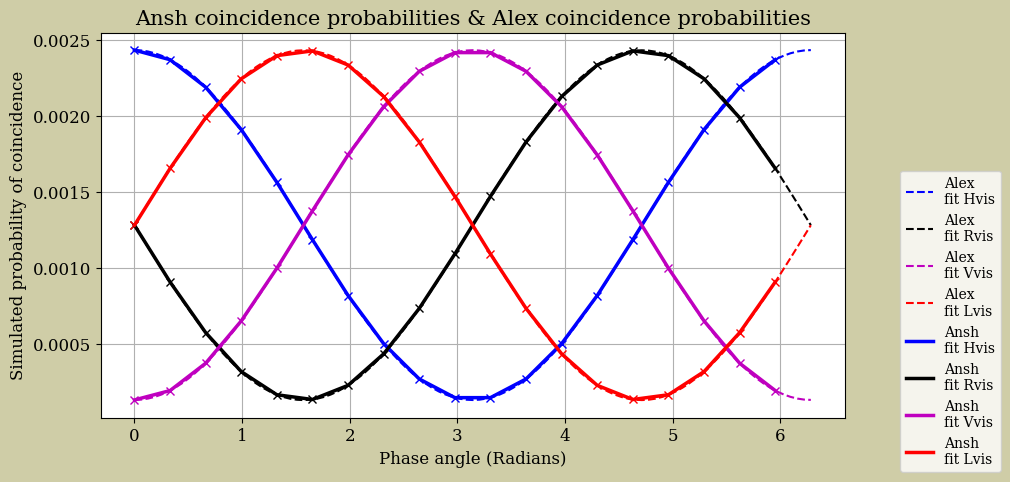

In [9]:
min_diff_index = 0
avg_visibility = 0

for i in range(len(params["idler_angles"])):
    visibility = (max(coincidences[min_diff_index][i]) - min(coincidences[min_diff_index][i]))/(max(coincidences[min_diff_index][i]) + min(coincidences[min_diff_index][i]))
    avg_visibility += visibility/len(params["idler_angles"])
print("Average visibility:", avg_visibility)

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# Creating fitting curves
fringe_domain = np.array(params["signal_angles"])
params0, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][0], p0=(80,1,1,1))
params1, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][1], p0=(80,1,1,1))
params2, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][2], p0=(80,1,1,1))
params3, _ = optimize.curve_fit(sinusoid, fringe_domain, coincidences[min_diff_index][3], p0=(80,1,1,1))

exp_params0, _ = optimize.curve_fit(sinusoid, experimental_domain, H_data, p0=(80,1,1,1))
exp_params1, _ = optimize.curve_fit(sinusoid, experimental_domain, L_data, p0=(80,1,1,1))
exp_params2, _ = optimize.curve_fit(sinusoid, experimental_domain, V_data, p0=(80,1,1,1))
exp_params3, _ = optimize.curve_fit(sinusoid, experimental_domain, R_data, p0=(80,1,1,1))

TNRfont = {'fontname':'serif'}

# Now, creating actual plots.

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12,5))
fig.patch.set_facecolor("#cfcda7")
plt.xticks(fontsize=12)
ax1.set_xlabel('Phase angle (Radians)', **TNRfont, fontsize = 12)
ax1.set_ylabel('Simulated probability of coincidence', **TNRfont, fontsize = 12)

# Plotting Simulation data
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][0][:-1], 'bx')
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][1][:-1], 'kx')
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][2][:-1], 'mx')
ax1.plot(fringe_domain[:-1], coincidences[min_diff_index][3][:-1], 'rx')

# Plotting sinusoidal fits
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params0)[:-1], fmt = 'b-', capsize=3, label = "Ansh\nfit Hvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params1)[:-1], fmt = 'k-', capsize=3, label = "Ansh\nfit Rvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params2)[:-1], fmt = 'm-', capsize=3, label = "Ansh\nfit Vvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params3)[:-1], fmt = 'r-', capsize=3, label = "Ansh\nfit Lvis", linewidth = 2.5)

plt.legend(loc = 'upper left')

# # Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.yticks(fontsize=12)
ax1.legend(loc='center left', bbox_to_anchor=(1.065, 0.9))


# # Create second axis
# ax2 = ax1.twinx()
# ax2.set_ylim([0, max(max(H_data), max(V_data), max(L_data))])
# ax2.set_ylabel(r'Experimental Coincidences (per $10^9$ pulses)', **TNRfont, fontsize = 12)

# # plotting experimental data
# ax1.errorbar(experimental_domain, H_data, fmt = 'bo', capsize=3)
# ax1.errorbar(experimental_domain, R_data, fmt = 'ko', capsize=3)
# ax1.errorbar(experimental_domain, V_data, fmt = 'mo', capsize=3)
# ax1.errorbar(experimental_domain, L_data, fmt = 'ro', capsize=3)

# Plotting experimental sinusoidal fits
ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params0), 'b-',  label = "Alex\nfit Hvis", linestyle='dashed')
ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params3), 'k-',  label = "Alex\nfit Rvis", linestyle='dashed')
ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params2), 'm-',  label = "Alex\nfit Vvis", linestyle='dashed')
ax1.plot(experimental_domain, sinusoid(experimental_domain, *exp_params1), 'r-',  label = "Alex\nfit Lvis", linestyle='dashed')



# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1.065, 0.25))

plt.yticks(fontsize=12)
ax1.set_title("Ansh coincidence probabilities & Alex coincidence probabilities", **TNRfont, fontsize = 15)
ax1.grid()

## Estimating system attenuation

In [7]:
# Working Run code
coincidences = []
idler_singles = []
signal_singles = []
coincidence_std = []

# New parameters for estimating system attenuation
det_effs = np.linspace(-25, -27, 15)
params["signal_angles"] = np.linspace(0, 2*np.pi, 20)
params["idler_angles"] = [0]
params["truncation"] = 4

for eff in det_effs:
    params["SIGNAL_DET_EFFICIENCY"] = 10**(eff/10)
    params["IDLER_DET_EFFICIENCY"] = 10**(eff/10)

    timeline = Timeline(1e12, formalism=POLARIZATION_FOCK_FORMALISM, truncation = params["truncation"])
    signal_receiver, source_node = setup_network(timeline, params)

    for idler_phase in params["idler_angles"]:    

        print("\nNew Idler phase:", idler_phase)
        signal_receiver.rotateIdler(idler_phase)
        for signal_phase in params["signal_angles"]:
            
            timeline.init()
            print("New Signal phase:", signal_phase)
            signal_receiver.rotateSignal(signal_phase)

            for j in range(params["num_bs_trials_per_phase"]):
                source_node.start()
                timeline.run()

            signal_receiver.collectSignalData()
        signal_receiver.reset()

    new_coincidences, new_signal_singles, new_idler_singles, new_coincidence_std = signal_receiver.get_data()
    signal_singles.append(new_signal_singles.copy())
    idler_singles.append(new_idler_singles.copy())
    coincidences.append(new_coincidences.copy())
    coincidence_std.append(new_coincidence_std.copy())


New Idler phase: 0
New Signal phase: 0.0


New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase: 4.6297154895007475
New Signal phase: 4.960409453036515
New Signal phase: 5.291103416572283
New Signal phase: 5.621797380108051
New Signal phase: 5.9524913436438185
New Signal phase: 6.283185307179586

New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Sign

In [ ]:
# This is the average coincidence probability for the 4 measurement basis for 4 seconds of 250MHz pulsed opration
# (10^9 pulses in total) for the C22_C46 operation case in the CLEO paper. 
reference_probability = 1.1725e-7

# Using that refernece probability, we find the value of system attenuation that we sweeped over in the last cell 
# that corresponds to the least difference with the reference coincidence probability. 
peak_coincidence_probs = []
min_diff = 1
min_diff_index = -1
for i in range(len(det_effs)):
    # print(len(coincidences[i]))
    probability = max(coincidences[i][0])
    diff = np.abs(probability - reference_probability)
    peak_coincidence_probs.append(probability - reference_probability)
    if diff < min_diff:
        min_diff_index = i
        min_diff = diff

print(f"system attenuation estimate: {det_effs[min_diff_index]} dB")


1.541539056117556e-07
1.4434044884300127e-07
1.3515166838064073e-07
1.2654780477554144e-07
1.1849162904334067e-07
1.1094828166586167e-07
1.0388512095445893e-07
9.727158304231947e-08
9.107904878276346e-08
8.528072057971127e-08
7.985150641637207e-08
7.476791107945884e-08
7.000793457399124e-08
6.555097736349114e-08
6.137775082656581e-08
system attenuation is: -25.571428571428573 dB


det eff -25.594942744745005


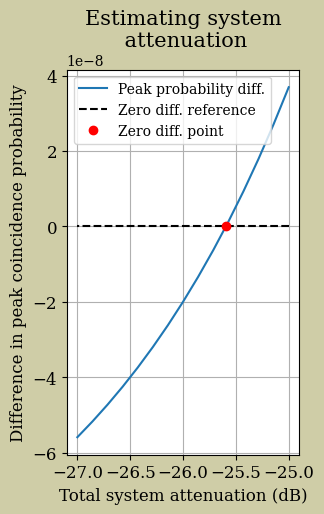

In [12]:
# Data acquisition and plotting
TNRfont = {'fontname':'serif'}

fig, ax1 = plt.subplots(figsize=(3,5))
fig.patch.set_facecolor("#cfcda7")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.plot(det_effs, peak_coincidence_probs, label = "Peak probability diff.")
plt.plot(det_effs, [0]*len(det_effs), color = "black", linestyle='dashed', label = "Zero diff. reference")

x = np.array(peak_coincidence_probs)
idx = np.argwhere(np.diff(np.sign(x))).flatten()[0]

# Linearly interpolating correct system attenuation 
interpolated_det_eff = det_effs[idx] - x[idx] * (det_effs[idx]-det_effs[idx+1])/(x[idx]-x[idx+1])
interpolated_diff = (x[idx]-x[idx+1])/(det_effs[idx]-det_effs[idx+1])*(interpolated_det_eff-det_effs[idx])+x[idx]

print("det eff", interpolated_det_eff)
plt.plot(interpolated_det_eff, interpolated_diff, 'ro', label = "Zero diff. point")
plt.title("Estimating system\n attenuation", **TNRfont, fontsize = 15)
plt.xlabel("Total system attenuation (dB)", **TNRfont, fontsize = 12)
ax1.set_ylabel("Difference in peak coincidence probability", **TNRfont, fontsize = 12)
plt.grid()
plt.legend()

## Local Hilbert space study

In [39]:
# Working Run code
coincidences = []
idler_singles = []
signal_singles = []
coincidence_std = []
times = []

# New parameters for estimating system attenuation
truncations = [1,2,3,4,5,6,7]
params["signal_angles"] = np.linspace(0, 2*np.pi, 20)
params["idler_angles"] = [0]

for trunc in truncations:
    start_time = time()
    timeline = Timeline(1e12, formalism=POLARIZATION_FOCK_FORMALISM, truncation = trunc)
    signal_receiver, source_node = setup_network(timeline, params)

    for idler_phase in params["idler_angles"]:    

        print("\nNew Idler phase:", idler_phase)
        signal_receiver.rotateIdler(idler_phase)
        for signal_phase in params["signal_angles"]:
            
            timeline.init()
            print("New Signal phase:", signal_phase)
            signal_receiver.rotateSignal(signal_phase)

            for j in range(params["num_bs_trials_per_phase"]):
                source_node.start()
                timeline.run()

            signal_receiver.collectSignalData()
        signal_receiver.reset()
    
    time_taken = time()-start_time
    print("time taken:", time_taken)
    times.append(time_taken)
    new_coincidences, new_signal_singles, new_idler_singles, new_coincidence_std = signal_receiver.get_data()
    signal_singles.append(new_signal_singles.copy())
    idler_singles.append(new_idler_singles.copy())
    coincidences.append(new_coincidences.copy())
    coincidence_std.append(new_coincidence_std.copy())

/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/home/asingal/home/.venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738


New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase: 4.6297154895007475
New Signal phase: 4.960409453036515
New Signal phase: 5.291103416572283
New Signal phase: 5.621797380108051
New Signal phase: 5.9524913436438185
New Signal phase: 6.283185307179586
time taken: 1.842961311340332

New Idler phase: 0
New Signal phase: 0.0
New Signal phase: 0.3306939635357677
New Signal phase: 0.6613879270715354
New Signal phase: 0.992081890607303
New Signal phase: 1.3227758541430708
New Signal phase: 1.6534698176788385
New Signal phase: 1.984163781214606
New Signal phase: 2.3148577447503738
New Signal phase: 2.6455517082861415
New Signal phase: 2.9762456718219092
New Signal phase: 3.306939635357677
New Signal phase: 3.6376335988934447
New Signal phase: 3.968327562429212
New Signal phase: 4.29902152596498
New Signal phase:

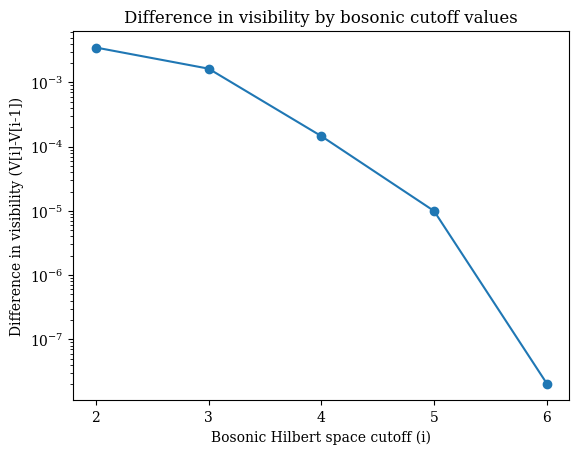

In [43]:
from matplotlib.ticker import MaxNLocator

vis = []
for coincidence in coincidences:
    vis.append((max(coincidence[0]) - min(coincidence[0]))/(max(coincidence[0]) + min(coincidence[0])))
vis_diffs = [np.abs(vis[i-1]-vis[i]) for i in range(1, len(vis)-1)]

fig, ax = plt.subplots()
ax.plot(truncations[1:-1], vis_diffs, '-o')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Difference in visibility by bosonic cutoff values")
plt.xlabel("Bosonic Hilbert space cutoff (i)")
plt.ylabel("Difference in visibility (V[i]-V[i-1])")
plt.yscale("log")

Text(0, 0.5, 'Time taken (s)')

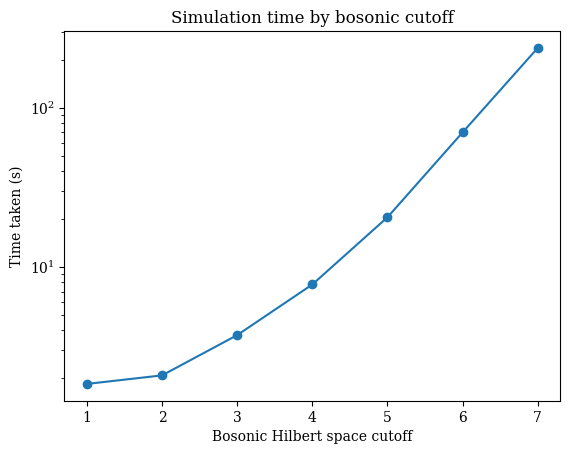

In [41]:
fig, ax = plt.subplots()
ax.plot(truncations, times, '-o')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.yscale("log")
plt.title("Simulation time by bosonic cutoff")
plt.xlabel("Bosonic Hilbert space cutoff")
plt.ylabel("Time taken (s)")

## Standard deviation in measurement results

Visibility idler: 0.8836996123237486
Visibility idler: 0.8920535276072841
Visibility idler: 0.8944170263877586
Visibility idler: 0.8920531602335277
Average visibility: 0.8905558316380797


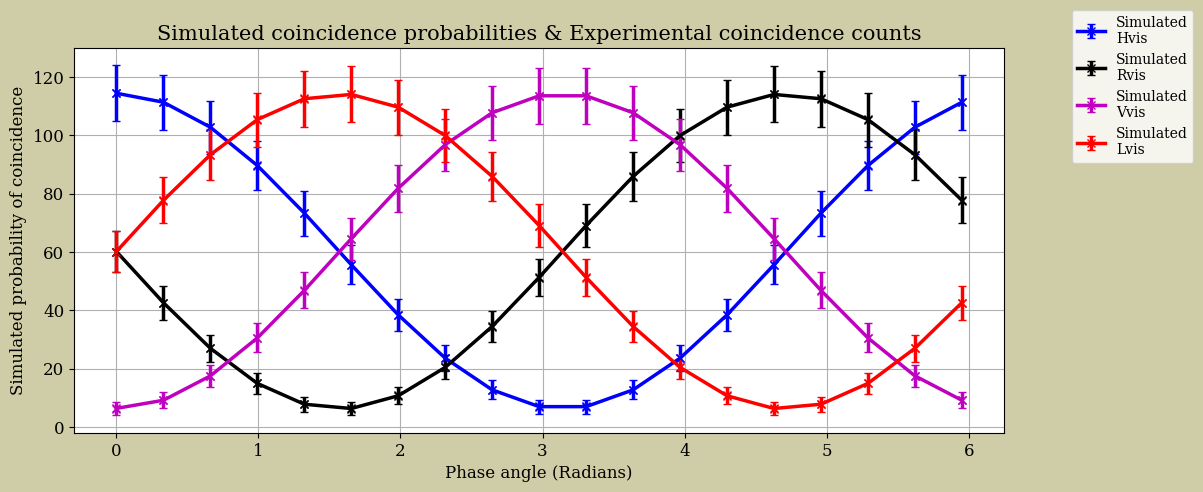

In [44]:
min_diff_index = 0
avg_visibility = 0

num_samples = 1e4

for i in range(len(params["idler_angles"])):
    visibility = (max(coincidences[min_diff_index][i]) - min(coincidences[min_diff_index][i]))/(max(coincidences[min_diff_index][i]) + min(coincidences[min_diff_index][i]))
    print("Visibility idler:",  visibility)
    avg_visibility += visibility/len(params["idler_angles"])
print("Average visibility:", avg_visibility)

def sinusoid(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

coincidences = np.array(coincidences)
coincidence_std = np.array(coincidence_std)

# Creating fitting curves
fringe_domain = np.array(params["signal_angles"])
params0, _ = optimize.curve_fit(sinusoid, fringe_domain, num_samples * coincidences[min_diff_index][0], p0=(80,1,1,1))
params1, _ = optimize.curve_fit(sinusoid, fringe_domain, num_samples * coincidences[min_diff_index][1], p0=(80,1,1,1))
params2, _ = optimize.curve_fit(sinusoid, fringe_domain, num_samples * coincidences[min_diff_index][2], p0=(80,1,1,1))
params3, _ = optimize.curve_fit(sinusoid, fringe_domain, num_samples * coincidences[min_diff_index][3], p0=(80,1,1,1))

exp_params0, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], H_data[:, 5][:-1], p0=(80,1,1,1))
exp_params1, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], L_data[:, 5][:-1], p0=(80,1,1,1))
exp_params2, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], V_data[:, 5][:-1], p0=(80,1,1,1))
exp_params3, _ = optimize.curve_fit(sinusoid, experimental_domain[:-1], R_data[:, 5][:-1], p0=(80,1,1,1))

TNRfont = {'fontname':'serif'}

# Now, creating actual plots.

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(12,5))
fig.patch.set_facecolor("#cfcda7")
plt.xticks(fontsize=12)
ax1.set_xlabel('Phase angle (Radians)', **TNRfont, fontsize = 12)
ax1.set_ylabel('Simulated probability of coincidence', **TNRfont, fontsize = 12)

# Plotting Simulation data
ax1.plot(fringe_domain[:-1], num_samples * coincidences[min_diff_index][0][:-1], 'bx')
ax1.plot(fringe_domain[:-1], num_samples * coincidences[min_diff_index][1][:-1], 'kx')
ax1.plot(fringe_domain[:-1], num_samples * coincidences[min_diff_index][2][:-1], 'mx')
ax1.plot(fringe_domain[:-1], num_samples * coincidences[min_diff_index][3][:-1], 'rx')

# Plotting sinusoidal fits
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params0)[:-1], yerr = coincidence_std[min_diff_index][0][:-1]*np.sqrt(num_samples), fmt = 'b-x', capsize=3, label = "Simulated\nHvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params1)[:-1], yerr = coincidence_std[min_diff_index][1][:-1]*np.sqrt(num_samples), fmt = 'k-x', capsize=3, label = "Simulated\nRvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params2)[:-1], yerr = coincidence_std[min_diff_index][2][:-1]*np.sqrt(num_samples), fmt = 'm-x', capsize=3, label = "Simulated\nVvis", linewidth = 2.5)
ax1.errorbar(fringe_domain[:-1], sinusoid(fringe_domain, *params3)[:-1], yerr = coincidence_std[min_diff_index][3][:-1]*np.sqrt(num_samples), fmt = 'r-x', capsize=3, label = "Simulated\nLvis", linewidth = 2.5)

plt.legend(loc = 'upper left')
ax1.set_title("Simulated coincidence probabilities & Experimental coincidence counts", **TNRfont, fontsize = 15)
ax1.grid()
# box = ax1.get_position()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.yticks(fontsize=12)
ax1.legend(loc='center left', bbox_to_anchor=(1.065, 0.9))